In [165]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import unidecode
import re
import seaborn as sns

movies = pd.read_csv(
    r"C:\Users\clarinha\Downloads\ml-1m\ml-1m\movies.dat",
    sep='::',
    engine='python',
    header=None,
    names=['id_filme', 'titulo', 'generos'],
    encoding='latin-1'
)

ratings = pd.read_csv(
    r"C:\Users\clarinha\Downloads\ml-1m\ml-1m\ratings.dat",
    sep='::',
    engine='python',
    header=None,
    names=['id_usuario', 'id_filme', 'nota', 'data_avaliacao'],
    encoding='latin-1'
)

users = pd.read_csv(
    r"C:\Users\clarinha\Downloads\ml-1m\ml-1m\users.dat",
    sep='::',
    engine='python',
    header=None,
    names=['id_usuario', 'genero', 'idade', 'profissao', 'cep'],
    encoding='latin-1'
)

In [134]:
traducao_generos = {
    "Action": "Ação", "Adventure": "Aventura", "Animation": "Animação", "Children's": "Infantil",
    "Comedy": "Comédia", "Crime": "Crime", "Documentary": "Documentário", "Drama": "Drama",
    "Fantasy": "Fantasia", "Film-Noir": "Filme Noir", "Horror": "Terror", "Musical": "Musical",
    "Mystery": "Mistério", "Romance": "Romance", "Sci-Fi": "Ficção Científica", "Thriller": "Suspense",
    "War": "Guerra", "Western": "Faroeste"
}


In [135]:
#remove dados duplicados
movies['generos_str'] = movies['generos'].apply(lambda x: '|'.join(x))
movies.drop_duplicates(subset=['id_filme', 'titulo', 'generos_str'], inplace=True)
movies.drop(columns=['generos_str'], inplace=True)

ratings.drop_duplicates(inplace=True)
users.drop_duplicates(inplace=True)
#trata valores nulos
movies.dropna(subset=['generos', 'titulo'], inplace=True)
ratings.dropna(subset=['nota', 'data_avaliacao'], inplace=True)
users.dropna(subset=['idade'], inplace=True)
#converte os dados
ratings['nota'] = ratings['nota'].astype(float)
ratings['data_avaliacao'] = pd.to_datetime(ratings['data_avaliacao'], unit='s')
users['idade'] = users['idade'].astype(int)
#colunas novas

#ano 
movies['ano'] = movies['titulo'].str.extract(r'\((\d{4})\)').astype(float)
movies['titulo'] = movies['titulo'].str.replace(r'\(\d{4}\)', '', regex=True)

#quantidade de generos
movies['qtd_generos'] = movies['generos'].apply(len)

#dia mes e ano da avaliacao
ratings['ano'] = ratings['data_avaliacao'].dt.year
ratings['mes'] = ratings['data_avaliacao'].dt.month
ratings['dia'] = ratings['data_avaliacao'].dt.day

#dados irrelevantes
ratings = ratings[ratings['id_filme'].isin(movies['id_filme'])]
ratings = ratings[ratings['id_usuario'].isin(users['id_usuario'])]

#nome dos filmes primeira letra maiuscula 
movies['titulo'] = movies['titulo'].apply(lambda x: unidecode.unidecode(x.lower()).title())

In [136]:
def garantir_lista(x):
    """
    garante que cada valor seja uma lista de generos traduzidos 
    se ja for lista retorna como ta
    se for string transforma em lista e traduz os generos
    Se nao for lista nem string retorna lista vazia
    """
    if isinstance(x, list):
        return x
    elif isinstance(x, str):
        return [traducao_generos.get(g, g) for g in x.split('|')] if x != '' else []
    else:
        return []

In [137]:
#preenche os nulos e transforma em lista 
movies['generos'] = movies['generos'].fillna('')
movies['generos'] = movies['generos'].apply(garantir_lista)

In [138]:
#deixa a data e hora no formato certo
ratings['data_avaliacao'] = pd.to_datetime(ratings['data_avaliacao'], unit='s')

In [139]:
media_notas = ratings.groupby('id_filme')['nota'].mean().reset_index()
media_notas = media_notas.merge(movies[['id_filme','titulo']], on='id_filme')
media_notas = media_notas.sort_values(by='nota', ascending=False)

In [140]:
print("\nTop 10 filmes com maior média de notas:")

print(media_notas[['titulo','nota']].head(10))


Top 10 filmes com maior média de notas:
                                   titulo  nota
3054                           Baby, The    5.0
3152                     Song Of Freedom    5.0
2955                    Ulysses (Ulisse)    5.0
3010                       Smashing Time    5.0
744          Gate Of Heavenly Peace, The    5.0
1652                    Follow The Bitch    5.0
926   Schlafes Bruder (Brother Of Sleep)    5.0
3414                               Lured    5.0
3367                   One Little Indian    5.0
3635                   Bittersweet Motel    5.0


In [141]:
print("Top 10 gêneros mais frequentes:")
for genero, qtd in contador_generos.most_common(10):
    print(f"{genero}: {qtd}")


Top 10 gêneros mais frequentes:
Drama: 1603
Comédia: 1200
Ação: 503
Suspense: 492
Romance: 471
Terror: 343
Aventura: 283
Ficção Científica: 276
Infantil: 251
Crime: 211


In [145]:
#removendo lista sql nao suporta
movies['generos'] = movies['generos'].apply(lambda x: '|'.join(x))

In [146]:
import sqlite3

conn = sqlite3.connect("movielens.db")
movies.to_sql("filmes", conn, if_exists="replace", index=False)
ratings.to_sql("avaliacoes", conn, if_exists="replace", index=False)
users.to_sql("usuarios", conn, if_exists="replace", index=False)
conn.close()

In [148]:
conn = sqlite3.connect("movielens.db")

query = """
SELECT filmes.titulo, COUNT(avaliacoes.nota) AS qtd_avaliacoes, AVG(avaliacoes.nota) AS media_nota
FROM avaliacoes
JOIN filmes ON avaliacoes.id_filme = filmes.id_filme
GROUP BY filmes.titulo
ORDER BY media_nota DESC
LIMIT 10;
"""
top_filmes = pd.read_sql_query(query, conn)
print(top_filmes)

conn.close()

                                titulo  qtd_avaliacoes  media_nota
0                    Ulysses (Ulisse)                1         5.0
1                     Song Of Freedom                1         5.0
2                       Smashing Time                2         5.0
3  Schlafes Bruder (Brother Of Sleep)                1         5.0
4                   One Little Indian                1         5.0
5                               Lured                1         5.0
6         Gate Of Heavenly Peace, The                3         5.0
7                    Follow The Bitch                1         5.0
8                   Bittersweet Motel                1         5.0
9                           Baby, The                1         5.0


                                generos  qtd_filmes
0                                 Drama         843
1                               Comédia         521
2                                Terror         178
3                         Comédia|Drama         162
4                       Comédia|Romance         142
..                                  ...         ...
296   Animação|Infantil|Musical|Romance           1
297  Animação|Infantil|Fantasia|Musical           1
298   Animação|Infantil|Fantasia|Guerra           1
299    Animação|Infantil|Drama|Fantasia           1
300   Animação|Infantil|Comédia|Romance           1

[301 rows x 2 columns]


C:\Users\clarinha\AppData\Local\Temp\ipykernel_4916\183110444.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=filmes_por_genero.head(10), x='qtd_filmes', y='generos', palette="viridis")


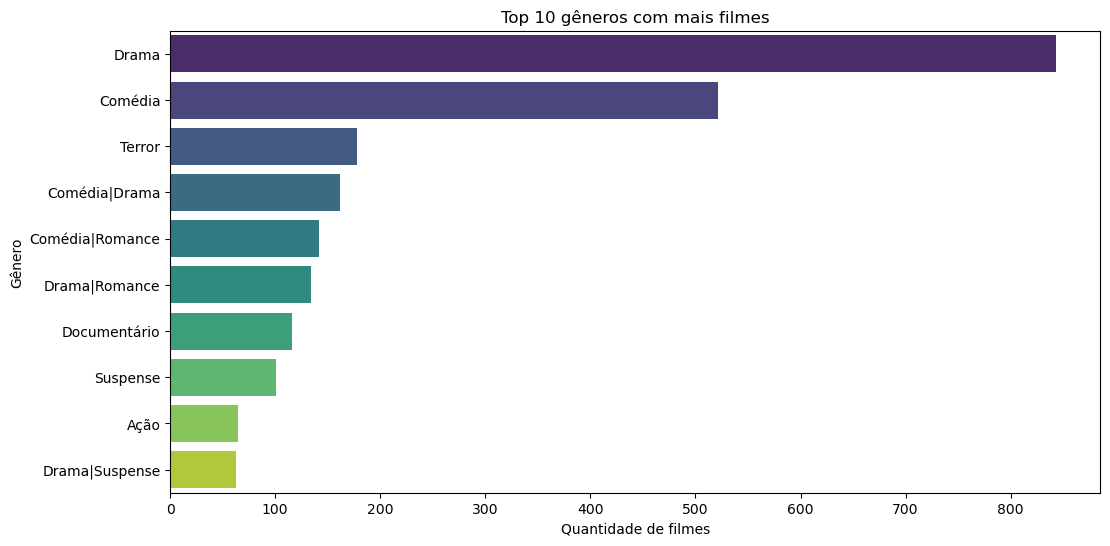

In [166]:
conn = sqlite3.connect("movielens.db")
#filmes por genero
query1 = """
SELECT generos, COUNT(*) AS qtd_filmes
FROM filmes
GROUP BY generos
ORDER BY qtd_filmes DESC;
"""
filmes_por_genero = pd.read_sql_query(query1, conn)
print(filmes_por_genero)

plt.figure(figsize=(12,6))
sns.barplot(data=filmes_por_genero.head(10), x='qtd_filmes', y='generos', palette="viridis")
plt.title("Top 10 gêneros com mais filmes")
plt.xlabel("Quantidade de filmes")
plt.ylabel("Gênero")
plt.show()

       ano  media_nota
0   1919.0    3.466667
1   1920.0    3.666667
2   1921.0    3.790323
3   1922.0    3.991597
4   1923.0    3.117647
..     ...         ...
76  1996.0    3.388502
77  1997.0    3.411654
78  1998.0    3.457729
79  1999.0    3.496459
80  2000.0    3.373341

[81 rows x 2 columns]


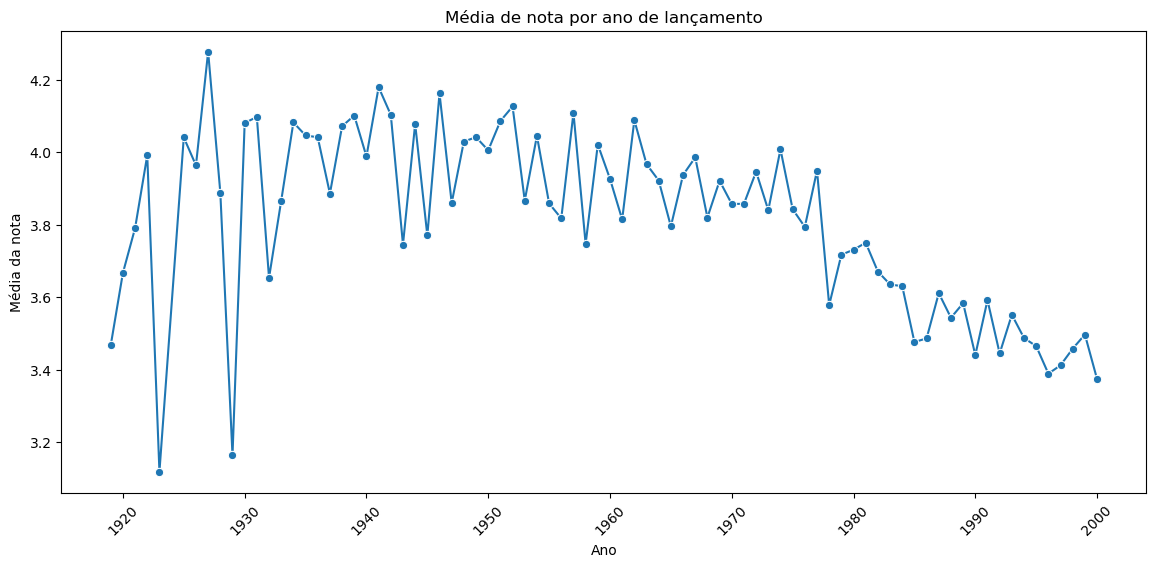

In [167]:
#media de nota por ano
query2 = """
SELECT filmes.ano, AVG(avaliacoes.nota) AS media_nota
FROM avaliacoes
JOIN filmes ON avaliacoes.id_filme = filmes.id_filme
GROUP BY filmes.ano
ORDER BY filmes.ano;
"""
media_por_ano = pd.read_sql_query(query2, conn)
print(media_por_ano)

plt.figure(figsize=(14,6))
sns.lineplot(data=media_por_ano, x='ano', y='media_nota', marker='o')
plt.title("Média de nota por ano de lançamento")
plt.xlabel("Ano")
plt.ylabel("Média da nota")
plt.xticks(rotation=45)
plt.show()

   id_usuario  qtd_avaliacoes
0        4169            2314
1        1680            1850
2        4277            1743
3        1941            1595
4        1181            1521
5         889            1518
6        3618            1344
7        2063            1323
8        1150            1302
9        1015            1286


C:\Users\clarinha\AppData\Local\Temp\ipykernel_4916\3810488488.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=usuarios_ativos, x='id_usuario', y='qtd_avaliacoes', palette="coolwarm")


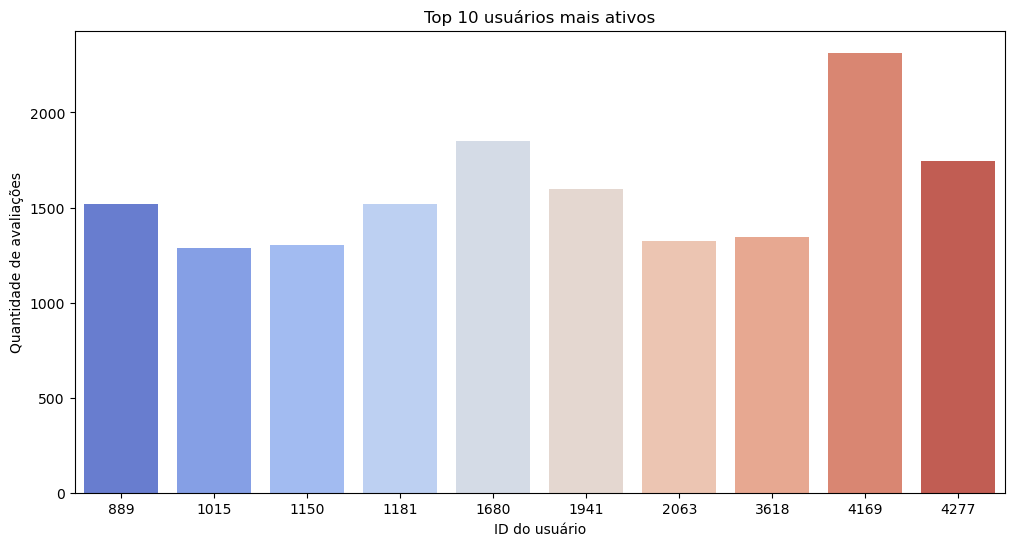

In [168]:
#usuarios mais ativos
query3 = """
SELECT id_usuario, COUNT(*) AS qtd_avaliacoes
FROM avaliacoes
GROUP BY id_usuario
ORDER BY qtd_avaliacoes DESC
LIMIT 10;
"""
usuarios_ativos = pd.read_sql_query(query3, conn)
print(usuarios_ativos)

plt.figure(figsize=(12,6))
sns.barplot(data=usuarios_ativos, x='id_usuario', y='qtd_avaliacoes', palette="coolwarm")
plt.title("Top 10 usuários mais ativos")
plt.xlabel("ID do usuário")
plt.ylabel("Quantidade de avaliações")
plt.show()

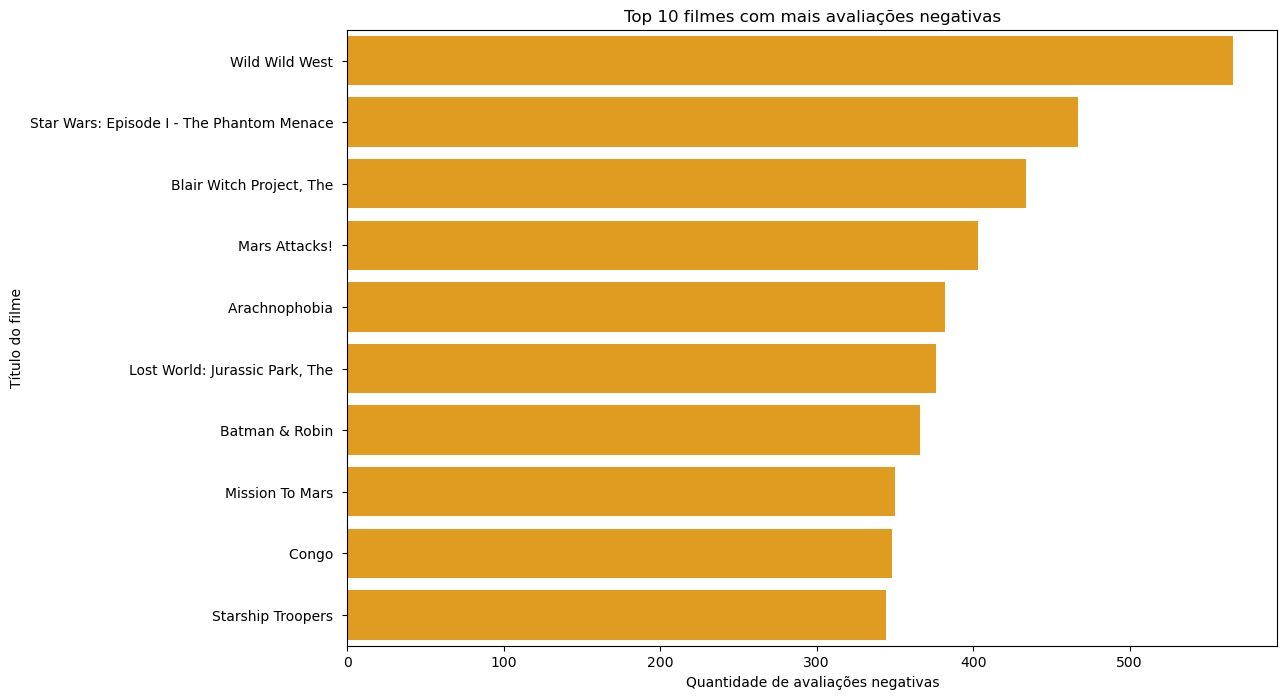

In [170]:
#avaliacoees negativas (nota <= 2)
query4 = """
SELECT filmes.titulo, COUNT(*) AS qtd_negativas
FROM avaliacoes
JOIN filmes ON avaliacoes.id_filme = filmes.id_filme
WHERE avaliacoes.nota <= 2
GROUP BY filmes.titulo
ORDER BY qtd_negativas DESC;
"""
plt.figure(figsize=(12,8))
sns.barplot(
    data=filmes_negativos.head(10),
    x='qtd_negativas',
    y='titulo',
    color='orange'  # Substitui palette
)
plt.title("Top 10 filmes com mais avaliações negativas")
plt.xlabel("Quantidade de avaliações negativas")
plt.ylabel("Título do filme")
plt.show()